# MDD with physics-aware factorization-based low-rank regularization

The purpose of this notebook is to demonstrate the importance of the regularization parameter $\lambda$ to the efficiency of our proposed method. It also reproduces the first example in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import inf

We first define functions to calcualte the residual and gradient of MDD with the proposed low-rank regularization

In [2]:
def diffQQt(xs, ia, ib):
    xs = xs[0]
    r = ia.dot(xs@xs.T) - ib
    return r

def gradQQt(xs, ir, ia):
    
    xs = xs[0] 
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T).dot(xs.conj())   

    return dd

Define the proximal operator of Frobenious norm:

In [3]:
def prox_Fro(v, t, lam):

    nv = norm(v,ord='fro')
    v  = v/(1+lam/t)
    
    nnv = norm(v, ord='fro')
    
    return v, nv**2 * 0.5, nnv**2 * 0.5

Below define the main function to solve the proposed MDD in an alternating style

In [4]:
def ipalm(grads, proxs, tau_guess, inc, diff, argv, ia, ib, xs0): 
    
    nblocks=len(grads)
    # initialize states for inertia
    xs1=list(xs0)
    xs2=list(xs0)
    
    it=0 
    
    lam = argv.lam

    nv, nnv = np.zeros(nblocks), np.zeros(nblocks)

    total_msf_old = inf

    while it < argv.nit: # and err > tol: 
        reg_msf = 0.0    
        #compute inertial coefficients
        if 0 == argv.inertia: 
            inertia = it/(it+3.0)
        else:
            inertia = argv.inertia
        
        for i in range(nblocks):

            yi = xs1[i] + inertia * (xs1[i] - xs0[i])
            zi = xs1[i] + inertia * (xs1[i] - xs0[i])
             
            xs2[i] = zi
    
            # Estimate the resuial and gradient with the current x
            res = diff(xs2, ia, ib)
            data_msf_cur = 0.5*norm(res, ord='fro')**2 
            gg = grads[i](xs2, res, ia)
                        
            ############################################################## 

            cnt = 0
            while(True):           
    
                tau = tau_guess[i] * inc[i]**cnt
                # print(cnt, tau) 
                y_tmp = yi - 1.0/tau * gg
                
                # x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                xs2[i] = x_new
                res = diff(xs2, ia, ib)

                data_msf_new = 0.5*norm(res, ord='fro')**2 
                # F(P(y_k))<Q(P(y_k), y_k)
                if data_msf_new < data_msf_cur + 0.5 * ( norm(x_new - y_tmp, ord='fro')**2 * tau - norm(gg, ord='fro')**2 / tau ) or cnt > 5: 
                    break
                cnt += 1
            
            # tau_guess[i] = tau
            reg_msf += nv[i]*lam[i]/tau

        total_msf_cur = reg_msf + data_msf_cur
        
        if argv.verbose:
            print("%15.3f%18d"%(total_msf_cur,cnt+1), end='', flush=True)
            for i in range(nblocks):
                print("%15.3f%15.3f"%(nv[i], nnv[i]), end='', flush=True)
            print("\n")
       
        if abs(total_msf_cur/total_msf_old-1.0) < argv.tol:
       
            break
        
        total_msf_old = total_msf_cur
      
        xs0 = list(xs1)
        xs1 = list(xs2)
        it+=1 
        
    
    return xs1

In [5]:
def generate_unique_random_integers(low, high, size):
    """ 
    Generate non-repetitive random integers within a specified range.
 
    Parameters:
    low (int): The lower bound of the range (inclusive).
    high (int): The upper bound of the range (exclusive).
    size (int): The number of unique random integers to generate.
 
    Returns:
    numpy.ndarray: An array of unique random integers.
    """
    if size > (high - low):
        raise ValueError("Size is larger than the range of unique numbers available.")
    np.random.seed(20240623)
    return np.random.choice(np.arange(low, high), size=size, replace=False)



## Data loading

In [6]:
# unique_random_integers = generate_unique_random_integers(low, high, high*25//100)
low, high = 0, 201
unique_random_integers = generate_unique_random_integers(low, high, high*50//100)
unique_random_integers = np.sort(unique_random_integers)

In [7]:
nt = 2025

ss = 0.0005

dat = np.load('../data/pup_pdown_seamsubsalt.npz', allow_pickle=True)

pup_f   = dat['pup'][:,unique_random_integers] 

pdown_f = dat['pdown'][:,unique_random_integers]



pup_f = np.fft.irfft(pup_f, axis=0, n=nt) 

pup_f = pup_f + ss*(np.random.normal(0,0.1,pup_f.shape)-0.)

pup_f = np.fft.rfft(pup_f, axis=0)



pdown_f = np.fft.irfft(pdown_f, axis=0, n=nt) 

pdown_f = pdown_f + ss*(np.random.normal(0,0.1,pdown_f.shape)-0.)

pdown_f = np.fft.rfft(pdown_f, axis=0)


In [8]:
pup_f.shape

(1013, 100, 151)

In [9]:
pup_f.shape

(1013, 100, 151)

In [10]:
energy = [np.linalg.norm(ipdown, 'fro') for ipdown in pdown_f] 

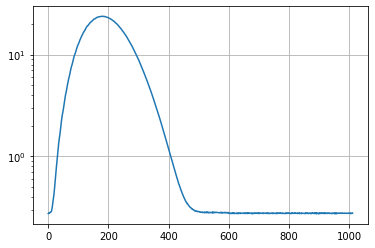

In [11]:
# ifstart and ifend can be determined from the figure below.
plt.yscale("log")
plt.plot(energy)
plt.grid()

In [12]:
ns, nr = pdown_f[0].shape
nk = nr//6

In [13]:
ns, nr

(100, 151)

In [14]:
ret = []

gradlist=[gradQQt]
proxlist=[prox_Fro]
inc = [2.0]

class args:
    lam = [0.1,]
    nit = 200000
    inertia = 0
    verbose = False
    tol = 1e-7

ifstart, ifend = 10, 599


 

## The proposed MDD with $\lambda=0.1$

In [15]:
ret = []

args.lam = [0.1]

x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j

# ifend = 150

for idx in range(ifstart, ifend):

    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffQQt, args, ia, ib, [x0,])
    
    ret.append(x1[0])


In [16]:
ret = np.array(ret)
ret1 = np.matmul(ret, ret.transpose(0,2,1))

g1 = np.zeros((ifend, nr, nr))*1j
g1[ifstart:] = ret1

g1 = np.fft.irfft(g1, n=nt, axis=0)

In [17]:
ret = []

args.lam = [.1]

x0 = np.zeros((nr, nr), dtype=np.complex64)

def diffAX(xs, ia, ib):
    xs = xs[0]
    xs = xs+xs.T
    xs *= 0.5
    r = ia.dot(xs) - ib
    return r

def gradAX(xs, ir, ia):
    
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T)*0.5   

    return dd

gradlist=[gradAX]

for idx in range(ifstart, ifend):
    print(idx)
    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffAX, args, ia, ib, [x0,])
    
    ret.append(x1[0])

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

In [18]:
ret = np.array(ret)
ret1 = np.matmul(ret, ret.transpose(0,2,1))

g0 = np.zeros((ifend, nr, nr))*1j
g0[ifstart:] = ret1

g0 = np.fft.irfft(g0, n=nt, axis=0)

In [19]:
ret = []

args.lam = [1]

x0 = np.zeros((nr, nr), dtype=np.complex64)

def diffAX(xs, ia, ib):
    xs = xs[0]
    xs = xs+xs.T
    xs *= 0.5
    r = ia.dot(xs) - ib
    return r

def gradAX(xs, ir, ia):
    
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T)*0.5   

    return dd

gradlist=[gradAX]

for idx in range(ifstart, ifend):
    
    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffAX, args, ia, ib, [x0,])
    
    ret.append(x1[0])

In [20]:
ret = np.array(ret)
ret1 = np.matmul(ret, ret.transpose(0,2,1))

g2 = np.zeros((ifend, nr, nr))*1j
g2[ifstart:] = ret1

g2 = np.fft.irfft(g2, n=nt, axis=0)

In [21]:
ret = []

args.lam = [1]

x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j

gradlist=[gradQQt]
proxlist=[prox_Fro]

for idx in range(ifstart, ifend):
    
    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffQQt, args, ia, ib, [x0,])
    
    ret.append(x1[0])


In [22]:
ret = np.array(ret)
ret1 = np.matmul(ret, ret.transpose(0,2,1))

g11 = np.zeros((ifend, nr, nr))*1j
g11[ifstart:] = ret1

g11 = np.fft.irfft(g11, n=nt, axis=0)

Text(0.5, 1.0, '$Low-rank$')

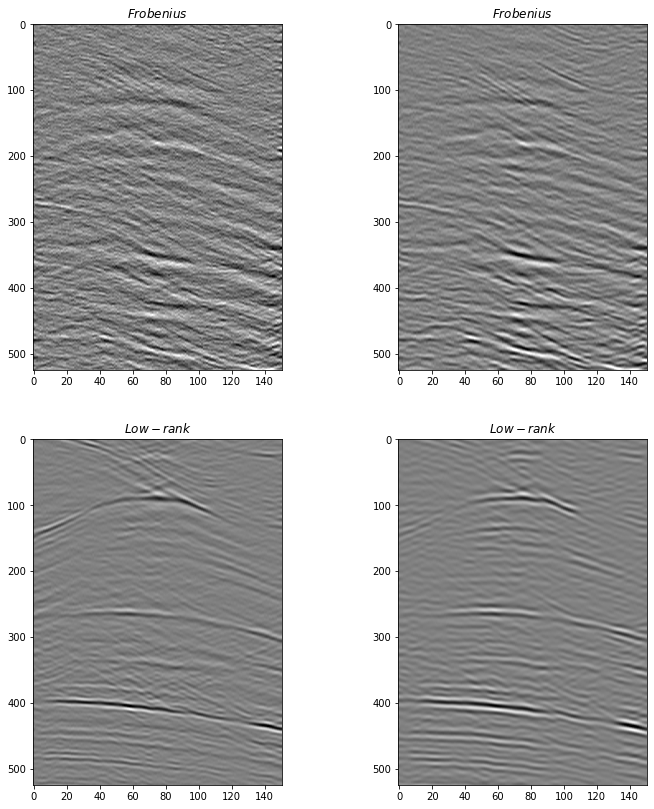

In [23]:
fig, axs = plt.subplots(2,2, figsize=(12,14))
pclip = 0.8#3

dat = g0[:525, 75] 
cc = np.abs(dat).max()
axs[0][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Frobenius$'
axs[0][0].set_title(title)

dat = g2[:525, 75] 
cc = np.abs(dat).max()
axs[0][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Frobenius$'
axs[0][1].set_title(title)

dat = g1[:525, 75] 
cc = np.abs(dat).max()
axs[1][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Low-rank$'
axs[1][0].set_title(title)

dat = g11[:525, 75] 
cc = np.abs(dat).max()
axs[1][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Low-rank$'
axs[1][1].set_title(title)

## plt.tight_layout(pad=-10., w_pad=0., h_pad=.0)